# GIS-data fundamentals

The vector data model represents the world using points, lines, and polygons. These have discrete, well-defined borders, meaning that vector datasets usually have a high level of precision (but not necessarily accuracy). The raster data model, on the other hand, divides the surface up into cells of constant size. Raster datasets are the basis of background images used in web-mapping and have been a vital source of geographic data since the origins of aerial photography and satellite-based remote sensing devices. Rasters aggregate spatially specific features to a given resolution, meaning that they are consistent over space and scalable, with many worldwide raster datasets available.

Which to use? The answer likely depends on your domain of application, and the datasets you have access to:

- Vector datasets and methods dominate the social sciences because human settlements and and processes (e.g., transport infrastructure) tend to have discrete borders
- Raster datasets and methods dominate many environmental sciences because of the reliance on remote sensing data

Python have strong support for both models. For vector data, we usually work with shapely and geopandas, while for raster data we work with rasterio.

In [3]:
#Import everything needed for vector data
import pandas as pd
import shapely
import geopandas as gpd

## Geopandas
In Geopandas, we are working with dataframes (can be familiar from the pandas) library, which is data on a tabular format, where one of the columns is a geometry column. The geometry column is essentially a mapper that maps all the data on the row, to a location on a map. This can i.e be a country, with information such as country name, population, area, etc.

For many applications, the high level vector layer class, which are essentially a data frame with geometry columns, are all that’s needed. However, it’s important to understand the structure of vector geographic objects and their component pieces for more advanced applications. The three main vector geographic data classes in Python are:

- GeoDataFrame, a class representing vector layers, with a geometry column (class GeoSeries) as one of the columns
- GeoSeries, a class that is used to represent the geometry column in GeoDataFrame objects
- shapely geometry objects which represent individual geometries, such as a point or a polygon
The first two classes (GeoDataFrame and GeoSeries) are defined in geopandas. The third class is defined in the shapely package, which deals with individual geometries, and is a main dependency of the geopandas package.

Normal vector files often ends with gpkg (Geopackage), geojson (json with a geometry attribute) or shp (ESRI shapefile). The high level function gpd.read_file() can read all of these files (and a ton more)

In [4]:
gdf = gpd.read_file('data/world.gpkg')
gdf.head()

,iso_a2,name_long,continent,region_un,subregion,type,area_km2,pop,lifeExp,gdpPercap,geometry
0,FJ,Fiji,Oceania,Oceania,Melanesia,Sovereign country,1.928997e+04,885806.0,69.960000,8222.253784,"MULTIPOLYGON (((-180.00000 -16.55522, -179.917..."
1,TZ,Tanzania,Africa,Africa,Eastern Africa,Sovereign country,9.327458e+05,52234869.0,64.163000,2402.099404,"MULTIPOLYGON (((33.90371 -0.95000, 31.86617 -1..."
2,EH,Western Sahara,Africa,Africa,Northern Africa,Indeterminate,9.627060e+04,NaN,NaN,NaN,"MULTIPOLYGON (((-8.66559 27.65643, -8.81783 27..."
3,CA,Canada,North America,Americas,Northern America,Sovereign country,1.003604e+07,35535348.0,81.953049,43079.142525,"MULTIPOLYGON (((-132.71001 54.04001, -133.1800..."
4,US,United States,North America,Americas,Northern America,Country,9.510744e+06,318622525.0,78.841463,51921.984639,"MULTIPOLYGON (((-171.73166 63.78252, -171.7911..."


With geopandas we can do a lot of operation on the data, and here follows some of the most important ones.

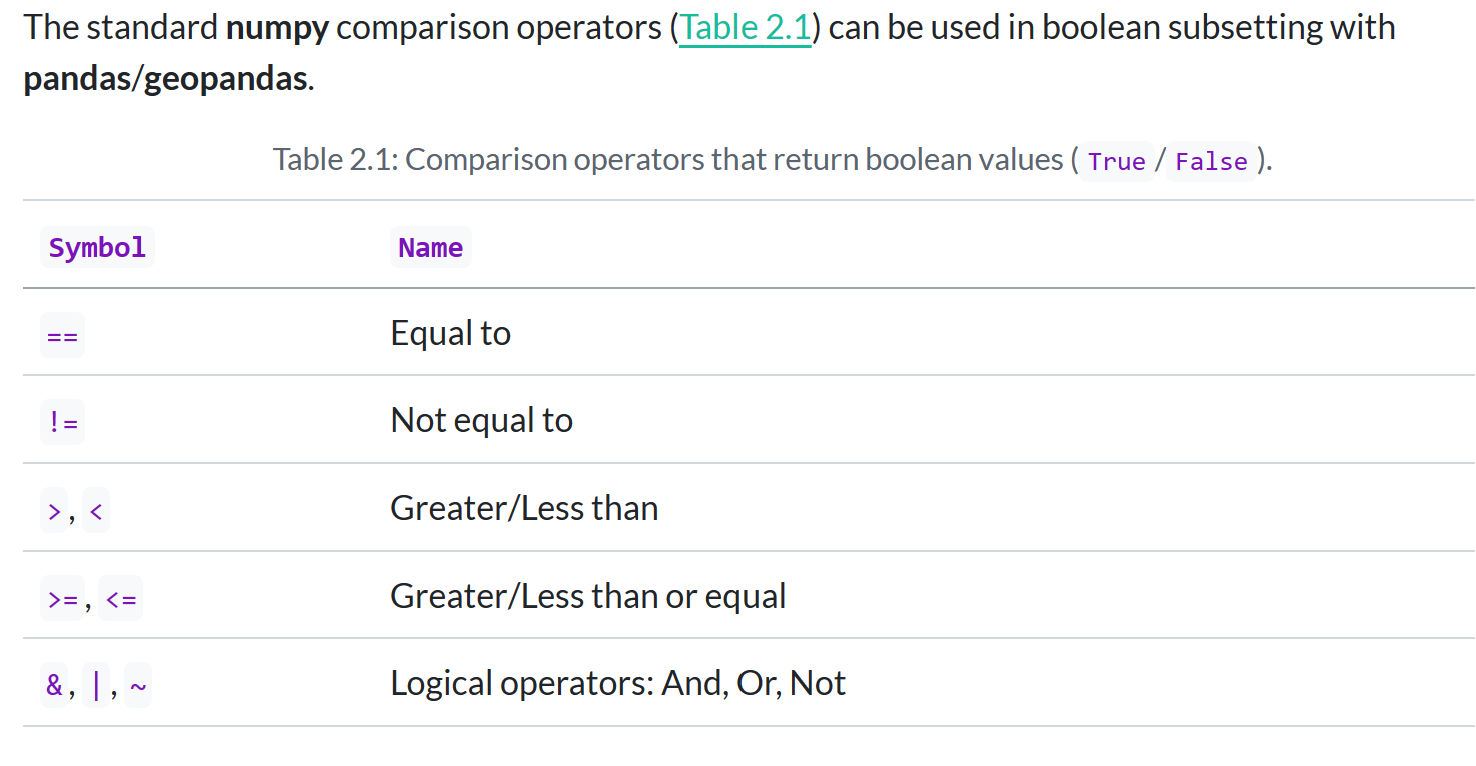

In [10]:
## Subsetting column
gdf_columns = gdf[['name_long', 'geometry']]

## Subsetting rows
gdf_rows = gdf.iloc[3:5]

## Subsetting rows and columns
gdf_rows_cols = gdf.iloc[3:5][['name_long', 'geometry']]

## filter by attribute
gdf_filter = gdf[gdf['name_long'] == 'Indonesia']

## filter by size
gdf_filter = gdf[gdf['area_km2'] > 10000000]
gdf_filter


,iso_a2,name_long,continent,region_un,subregion,type,area_km2,pop,lifeExp,gdpPercap,geometry
3,CA,Canada,North America,Americas,Northern America,Sovereign country,1.003604e+07,35535348.0,81.953049,43079.142525,"MULTIPOLYGON (((-132.71001 54.04001, -133.1800..."
18,RU,Russian Federation,Europe,Europe,Eastern Europe,Sovereign country,1.701851e+07,143819666.0,70.743659,25284.586202,"MULTIPOLYGON (((-180.00000 64.97971, -179.4326..."
159,AQ,Antarctica,Antarctica,Antarctica,Antarctica,Indeterminate,1.233596e+07,NaN,NaN,NaN,"MULTIPOLYGON (((-180.00000 -89.90000, 179.9999..."


We can also look at the data with an interactive map, with one of my favorite functions, .explore()

In [11]:
gdf.explore()

## CRS

CRS, short for coordinate reference system, might be one of the trickiest parts of working with GIS-data. All geographic layers or datasets should have a CRS. It defines a set of rules for assigning numerical coordinates to locations. These coordinates typically include latitude, longitude, and sometimes elevation.

The importance of a Coordinate Reference System lies in its role in providing a standardized way to represent spatial data. It ensures consistency in mapping and geospatial analysis, allowing different maps and datasets to be accurately aligned and integrated. Without a common CRS, spatial information from various sources might not align correctly, leading to errors and misinterpretations in applications such as navigation, geographic information systems (GIS), and cartography.

The two most normal CRS is EPSG:4326 (lat/lon) and EPSG:3857 (Universal transverse mercator). EPSG4326 represents the common latitude and longitude system, while EPSG:3857 or similar UTM projections is a CRS where we have projected the circular shape of the earth to a 2D surface, commonly used in web applications and spatial operations (calculate area, centroid, etc)

We use gdf.crs to get information of the CRS that is being used, and gdf.to_crs("EPSG:4326") if we want to set the gdf to this CRS.

In [12]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Before performing spatial analysis on the data, we need to change the CRS to the correct projections, and this can be very tricky. Luckily, geopandas have an amazing function for this which does everythign very simple.

In [14]:
gdf = gdf.to_crs(gdf.estimate_utm_crs())
gdf.crs

<Projected CRS: EPSG:32730>
Name: WGS 84 / UTM zone 30S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°W and 0°W, southern hemisphere between 80°S and equator, onshore and offshore.
- bounds: (-6.0, -80.0, 0.0, 0.0)
Coordinate Operation:
- name: UTM zone 30S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Raster data

The spatial raster data model represents the world with the continuous grid of cells, and is very similar to how we represent images. Spatial rasters is actually images, with some metadata. It is this metadata that makes the raster a raster, in that it tells us the geographic position of this image. Raster data is used a lot in remote sensing (satellite images), and data that is difficult to represents by a vector layer, such as population, elevation, temperature or land cover. 

Raster data can both be continuous which is typical for elevation, slope, etc, or categorical in f.ex land cover.

For raster data we are normally working with the rasterio package, which lets us work with the raster as a numpy array, with a seperate objecting holding the metadata of the raster. Numpy is amazing to work with arrays, matrices, etc (anything related to numbers). 

Rasters is more difficult to work with than vector data (my opinion), as we first need to initialize a connection to the raster (with rasterio.open), before we are able to read the data from it (with the connection.read). 

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import rasterio.plot

src = rasterio.open('data/srtm.tif')
src

<open DatasetReader name='data/srtm.tif' mode='r'>

In [18]:
data = src.read(1)
data

array([[1728, 1718, 1715, ..., 2654, 2674, 2685],
       [1737, 1727, 1717, ..., 2649, 2677, 2693],
       [1739, 1734, 1727, ..., 2644, 2672, 2695],
       ...,
       [1326, 1328, 1329, ..., 1777, 1778, 1775],
       [1320, 1323, 1326, ..., 1771, 1770, 1772],
       [1319, 1319, 1322, ..., 1768, 1770, 1772]], dtype=uint16)

The resulting object is a numpy array, with either two or three dimensions:

- Three dimensions, when reading more than one layer (e.g., .read() or .read([1,2])). In such case, the dimensions pattern is (layers, rows, columns)
- Two dimensions, when reading one specific layer (e.g., .read(1)). In such case, the dimensions pattern is (rows, columns)

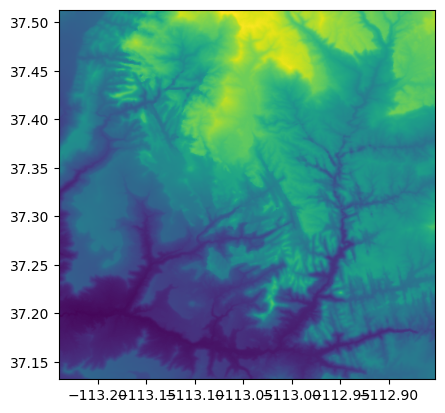

<Axes: >

In [22]:
rasterio.plot.show(src)

In [23]:
src.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 65535.0,
 'width': 465,
 'height': 457,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0008333333332777796, 0.0, -113.23958321278403,
        0.0, -0.0008333333332777843, 37.512916763165805)}

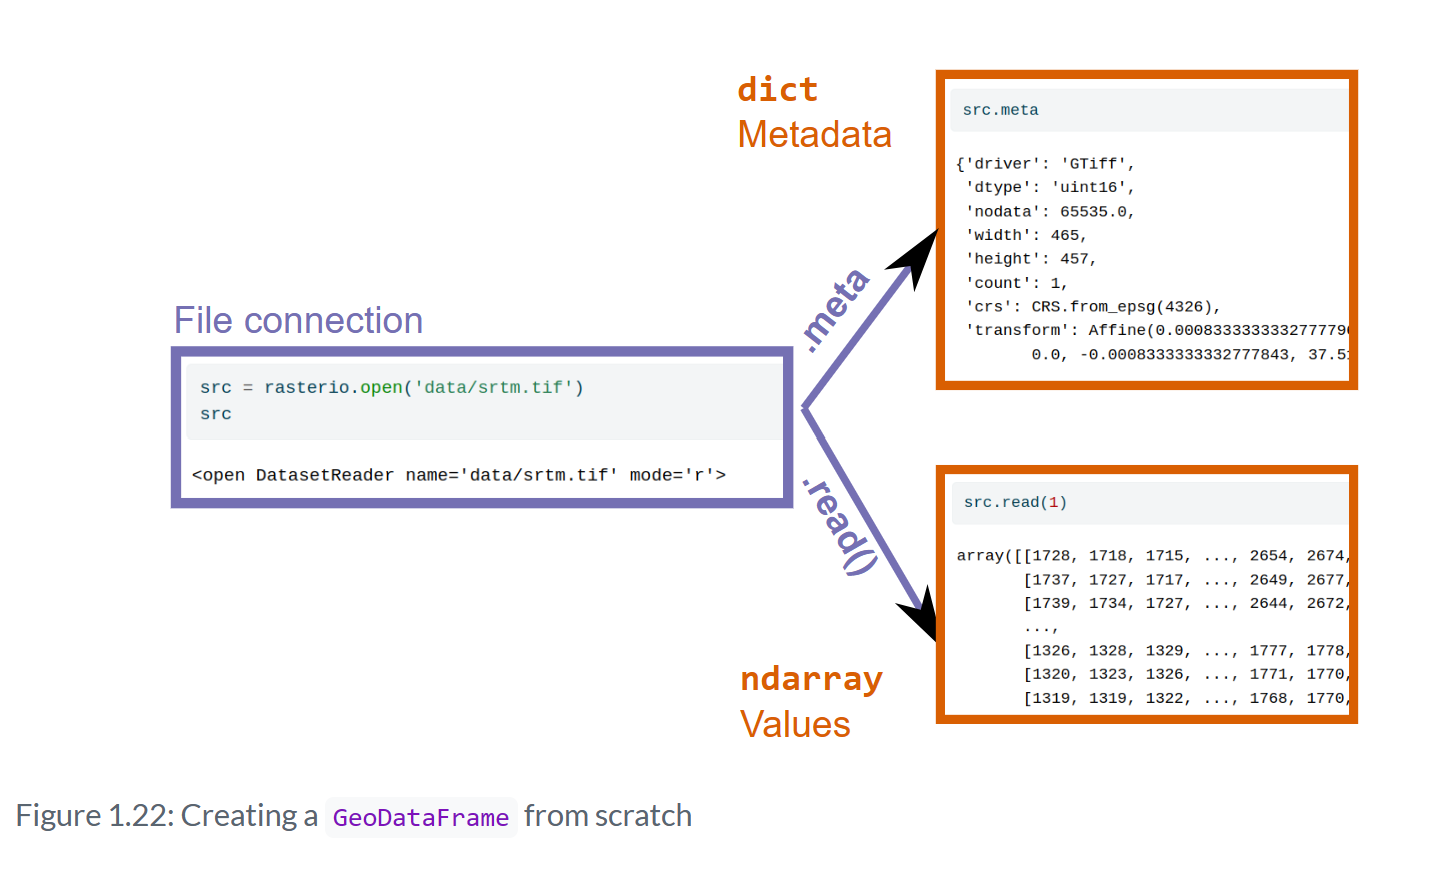